# Model Selection

## Import libraries

In [1]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pickle

## Load data

In [2]:
with open('pca_data.pkl', 'rb') as f:
    pca_data = pickle.load(f)

X_raw = pca_data['X_raw']
y = pca_data['y']

## Select models to train

In [4]:
available_models = {
    "RandomForest": RandomForestClassifier(random_state=42),
    "LogisticRegression": LogisticRegression(random_state=42, max_iter=1000),
    "SVM": SVC(random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "NeuralNetwork": MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42),
}

# User input: Specify models to use
selected_models = ["RandomForest", "NeuralNetwork"]

# User input: Specify number of folds for cross-validation
use_pca = True  # Set to False to skip PCA
n_components = 2  # Number of principal components to project onto (if use_pca=True)

## Training

In [8]:
# Initialize cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_results = {}
best_model = None
best_mean_accuracy = 0.0

# Train each selected model
for model_name in tqdm(selected_models, desc="Training Models"):
    if model_name not in available_models:
        print(f"Model {model_name} is not available.")
        continue

    # Initialize model
    model = available_models[model_name]

    # Define pipeline components
    steps = []
    steps.append(("scaler", StandardScaler()))
    if use_pca:
        steps.append(("pca", PCA(n_components=n_components)))
    steps.append(("classifier", model))

    # Create pipeline
    pipeline = Pipeline(steps)

    # Perform CV
    print(f"\nTraining {model_name} with 5-fold Cross-Validation (PCA: {use_pca}, Components: {n_components}):")
    cv_scores = []
    for score in tqdm(cross_val_score(pipeline, X_raw, y, cv=cv), desc=f"{model_name} Progress"):
        cv_scores.append(score)

    # Store results
    mean_accuracy = np.mean(cv_scores)
    std_accuracy = np.std(cv_scores)
    cv_results[model_name] = {
        "scores": cv_scores,
        "mean_accuracy": mean_accuracy,
        "std_accuracy": std_accuracy,
        "pipeline": pipeline,
    }

    # Check if this model is the best so far
    if mean_accuracy > best_mean_accuracy:
        best_mean_accuracy = mean_accuracy
        best_model = pipeline  # Save the pipeline of the best model

    # Display results for the current model
    print(f"\n{model_name} Cross-Validation Scores:")
    print(cv_scores)
    print(f"Mean CV Accuracy: {mean_accuracy:.2%}")
    print(f"Standard Deviation of CV Accuracy: {std_accuracy:.2%}")
    print("_" * 100)

Training Models:   0%|          | 0/2 [00:00<?, ?it/s]


Training RandomForest with 5-fold Cross-Validation (PCA: True, Components: 2):


Training Models:  50%|█████     | 1/2 [00:00<00:00,  1.55it/s]


RandomForest Cross-Validation Scores:
[0.9333333333333333, 0.9, 0.8, 1.0, 0.8]
Mean CV Accuracy: 88.67%
Standard Deviation of CV Accuracy: 7.77%
____________________________________________________________________________________________________

Training NeuralNetwork with 5-fold Cross-Validation (PCA: True, Components: 2):


Training Models: 100%|██████████| 2/2 [00:01<00:00,  1.18it/s]


NeuralNetwork Cross-Validation Scores:
[0.9, 0.8666666666666667, 0.8666666666666667, 1.0, 0.8666666666666667]
Mean CV Accuracy: 90.00%
Standard Deviation of CV Accuracy: 5.16%
____________________________________________________________________________________________________


## Save best model

In [9]:
with open('best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

print(f"\nBest Model: {best_model.named_steps['classifier'].__class__.__name__}")
print(f"Best Model Mean CV Accuracy: {best_mean_accuracy:.2%}")


Best Model: MLPClassifier
Best Model Mean CV Accuracy: 90.00%


## Cross Validation Results

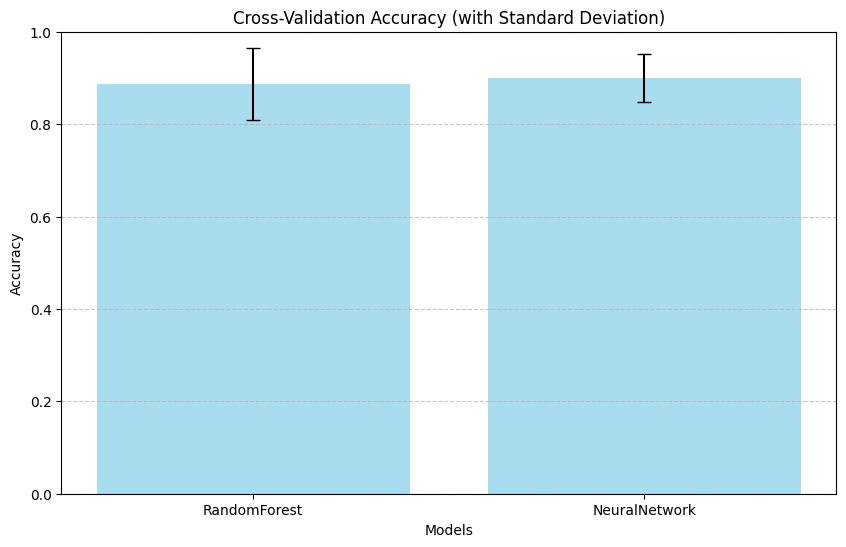

In [11]:
def plot_cv_results(cv_results):
    model_names = []
    cv_means = []
    cv_stds = []

    for model_name, result in cv_results.items():
        model_names.append(model_name)
        cv_means.append(result["mean_accuracy"])
        cv_stds.append(result["std_accuracy"])

    plt.figure(figsize=(10, 6))
    plt.bar(model_names, cv_means, yerr=cv_stds, capsize=5, alpha=0.7, color='skyblue')
    plt.title('Cross-Validation Accuracy (with Standard Deviation)')
    plt.ylabel('Accuracy')
    plt.xlabel('Models')
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

plot_cv_results(cv_results)